## Import library


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16


#Download Data From Kaggle


In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od

od.download(
	"https://www.kaggle.com/datasets/alvinbintang/sibi-dataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: takehiruka
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alvinbintang/sibi-dataset


100%|██████████| 2.70G/2.70G [02:50<00:00, 17.0MB/s]


## Load dataset

In [4]:
data_dir = '/content/sibi-dataset/SIBI'

X = []
y = []

for label in os.listdir(data_dir):
    if label not in ['A-Y', '.', '..']:
        label_dir = os.path.join(data_dir, label)
        for image_path in os.listdir(label_dir):
            image = load_img(os.path.join(label_dir, image_path), target_size=(224, 224), color_mode='rgb')
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)  # Convert to 4D tensor
            X.append(image)
            y.append(label)

In [5]:
# Konversi data menjadi array numpy
X = np.array(X)
y = np.array(y)

# Encode label
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Konversi label menjadi one-hot encoding
y = tf.keras.utils.to_categorical(y, len(np.unique(y)))

# Split data menjadi train, test, dan validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Augmentasi data train
train_datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)
# Reshape X_train and X_val to remove the extra dimension
X_train = X_train.reshape(-1, 224, 224, 3)
X_val = X_val.reshape(-1, 224, 224, 3)

# Memuat data train dan validation dengan generator
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=32)

In [6]:
print("Total training images:", X_train.shape[0])
print("Total validation images:", X_val.shape[0])

Total training images: 3696
Total validation images: 792


## Modeling

In [12]:
# Membuat model
model = tf.keras.Sequential([
    #conv dan pool layer 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Using RGB Image For Training
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #conv dan pool layer 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #conv dan pool layer 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #conv dan pool layer 4
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #conv dan pool layer 5
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #conv dan pool layer 6
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='softmax')
])

#  Mengkompilasi model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_3 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

In [ ]:
# base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# base_model.trainable = False

# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(24, activation='softmax')
# ])

# model.compile(loss='categorical_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#               metrics=['accuracy'])

# model.summary()

In [13]:
# fungsi callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

# Train model

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Epoch 1/30
116/116 [==============================] - 56s 481ms/step - loss: 2.9501 - accuracy: 0.1096 - val_loss: 3.1107 - val_accuracy: 0.1237 - lr: 1.0000e-04
Epoch 2/30
116/116 [==============================] - 50s 433ms/step - loss: 2.7054 - accuracy: 0.1748 - val_loss: 2.9319 - val_accuracy: 0.1944 - lr: 1.0000e-04
Epoch 3/30
116/116 [==============================] - 54s 469ms/step - loss: 2.4359 - accuracy: 0.2551 - val_loss: 2.6599 - val_accuracy: 0.2601 - lr: 1.0000e-04
Epoch 4/30
116/116 [==============================] - 53s 458ms/step - loss: 2.1699 - accuracy: 0.3222 - val_loss: 2.3240 - val_accuracy: 0.3308 - lr: 1.0000e-04
Epoch 5/30
116/116 [==============================] - 50s 427ms/step - loss: 1.9903 - accuracy: 0.3690 - val_loss: 2.0333 - val_accuracy: 0.3965 - lr: 1.0000e-04
Epoch 6/30
116/116 [==============================] - 51s 442ms/step - loss: 1.8449 - accuracy: 0.4129 - val_loss: 1.8719 - val_accuracy: 0.4609 - lr: 1.0000e-04
Epoch 7/30
116/116 [========

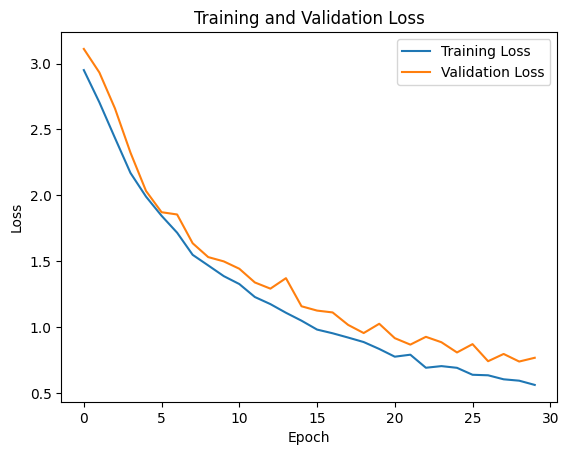

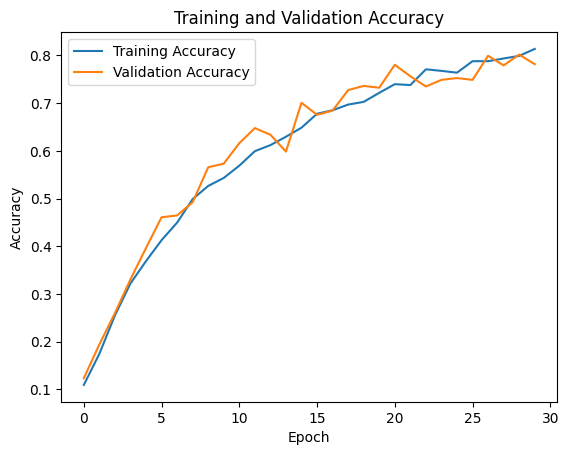

In [20]:
# Train the model
history = model.fit(
    train_generator,
    epochs= 30,
    validation_data=validation_generator,
    callbacks= [early_stopping, lr_scheduler]
)

In [ ]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Train Model With additional Dropout

Epoch 1/70
116/116 [==============================] - 21s 181ms/step - loss: 0.6815 - accuracy: 0.7708 - val_loss: 0.8163 - val_accuracy: 0.7904 - lr: 1.0000e-04
Epoch 2/70
116/116 [==============================] - 20s 173ms/step - loss: 0.6435 - accuracy: 0.7965 - val_loss: 0.8825 - val_accuracy: 0.7702 - lr: 1.0000e-04
Epoch 3/70
116/116 [==============================] - 21s 179ms/step - loss: 0.6149 - accuracy: 0.7995 - val_loss: 0.8762 - val_accuracy: 0.7563 - lr: 1.0000e-04
Epoch 4/70
116/116 [==============================] - 20s 171ms/step - loss: 0.6011 - accuracy: 0.8052 - val_loss: 0.8455 - val_accuracy: 0.7664 - lr: 1.0000e-04
Epoch 5/70
116/116 [==============================] - 21s 180ms/step - loss: 0.5669 - accuracy: 0.8111 - val_loss: 0.7628 - val_accuracy: 0.7929 - lr: 1.0000e-04
Epoch 6/70
116/116 [==============================] - 20s 173ms/step - loss: 0.5468 - accuracy: 0.8101 - val_loss: 0.7702 - val_accuracy: 0.7942 - lr: 1.0000e-04
Epoch 7/70
116/116 [========

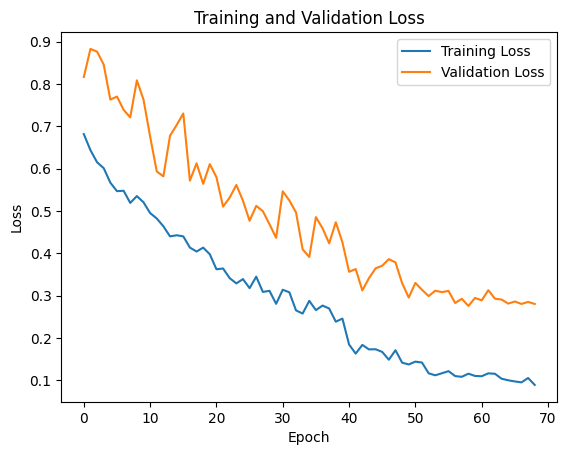

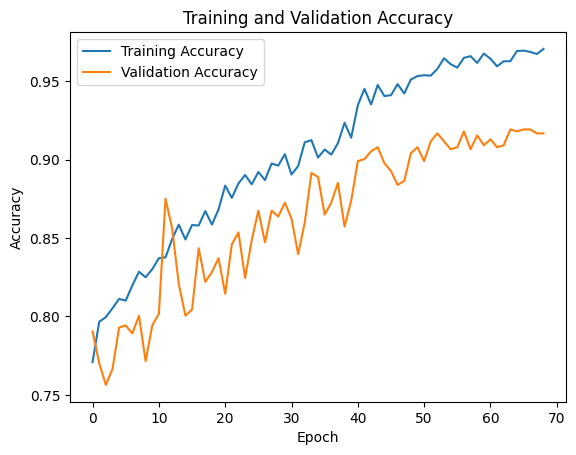

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs= 70,
    validation_data=validation_generator,
    callbacks= [early_stopping, lr_scheduler]
)

    # Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluasi Model

In [ ]:
# Evaluate model on test dataset
test_loss, test_acc = model.evaluate(validation_generator)
train_loss, train_acc = model.evaluate(train_generator)

print("Test Loss on validation:", test_loss)
print("Test Accuracy on validation:", test_acc)

print("\nTest Loss on train:", train_loss)
print("Test Accuracy on train:", train_acc)

116/116 [==============================] - 14s 122ms/step - loss: 0.0994 - accuracy: 0.9840
Test Loss on validation: 0.2758817672729492
Test Accuracy on validation: 0.9154040217399597

Test Loss on train: 0.09943817555904388
Test Accuracy on train: 0.9840368032455444


# Convert model ke TensofFlow Lite

In [21]:
# Model Save
model.export("model")

Saved artifact at 'model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='conv2d_6_input')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  131979390329680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131978756716000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131978756706672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131979019977120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131978756470240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131978756466896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131978756715120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131978756714064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131978756707024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131978756467952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131978756462672: Tenso

In [22]:
converter = tf.lite.TFLiteConverter.from_saved_model("model")

tflite_model = converter.convert()
# Save the TensorFlow Lite model
with open('model-SIBI.tflite', 'wb') as f:
  f.write(tflite_model)